In [1]:
import pandas as pd
import shutil
import funcs_sorting as sort
import funcs_for_results_tables as get_results
import glob
import funcs_plot_intrinsic_props as pl_intr
import matplotlib.pyplot as plt
import funcs_events_post_analysis
plt.style.use('seaborn')
import numpy as np
plt.style.use('./style_plot_intrinsic.mplstyle')


def create_cell_ID_unchanged(df, fn_col, chan_col, slice_col):
    cell_IDs = []
    for i in range(len(df)):
        fn = df[fn_col][i][:-7]
        slic = df[slice_col][i]
        chan = str(df[chan_col][i])
        cell_IDs.append(fn + '_' + slic + '_' + chan)

    df.insert(len(df.columns), 'cell_ID_complete', cell_IDs)
    return df

def create_new_cell_IDs(df):

    if 'cell_ID_new' in df.columns:
        return df

    patcher_dict = {'Verji':'vm', 'Rosie': 'rs'}
    cell_IDs_new = []
    for i in range(len(df)):
        cell_ID = patcher_dict[df['patcher'].tolist()[i]] + df['cell_ID'].tolist()[i]
        cell_IDs_new.append(cell_ID)
    df['cell_ID_new'] = cell_IDs_new
    return df

def get_true_repatched_cells(repatch_df):
    
    if 'cell_ID_new' not in repatch_df.columns:
        repatch_df = create_new_cell_IDs(repatch_df)

    not_repatched_cells = []
    for cell in repatch_df['cell_ID_new'].unique():
        if len(repatch_df[repatch_df['cell_ID_new'] == cell]) < 2:
            not_repatched_cells.append(cell)

    for cell in not_repatched_cells:
        repatch_df = repatch_df.drop(repatch_df.index[repatch_df['cell_ID_new'] == cell])     
    repatch_df.reset_index(inplace = True, drop = True)
    return repatch_df


/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/code/Human-slice-scripts/detect_peaks.py:11: UserWarning: A newest version is available at https://pypi.org/project/detecta/
  warnings.warn('A newest version is available at https://pypi.org/project/detecta/')


In [2]:
# in case of missing files, copy them to an additional recordings folder

# human_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/'
# for i in range(len(missing_fns)):
#     OP = df_meta['OP'][df_meta['Name of recording'].tolist().index(missing_fns[i])]
#     patcher = df_meta['patcher'][df_meta['Name of recording'].tolist().index(missing_fns[i])]
#     work_dir = sort.get_work_dir(human_dir, OP, patcher)

#     shutil.copy(os.path.join(work_dir, missing_fns[i]), '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/meta_events/recordings_add/')

In [3]:
human_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/'
exp_view = pd.read_excel(glob.glob(human_dir + '*experiments_overview.xlsx')[0])

df_meta = pd.read_excel('/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/data/human/meta_events/meta_files_to_analyse/2024-06-11spontan_meta.xlsx')
df_intr_all = pd.read_excel('/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/human/data/summary_data_tables/intrinsic_properties/2024-06-17_collected.xlsx')
df_spontan = pd.read_excel('/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/human/data/summary_data_tables/events/all_2024-06-06miniML_analyzed_all.xlsx')

df_intr_repatch = df_intr_all[df_intr_all['repatch'] == 'yes'].reset_index(drop = True)

In [4]:
repatch, days = [], []
for i,cell in enumerate(df_spontan['cell_ID']):
    if cell in df_intr_repatch['cell_ID'].unique():
        repatch.append('yes')
    else:
        repatch.append('no')

    if df_spontan['hrs_incubation'][i] == 0:
        days.append('D1')
    else:
        days.append('D2')

df_spontan.insert(8, 'day', days)
df_spontan.insert(9, 'repatch', repatch)

In [5]:
#check if cell IDs appear twice, if not remove
df_intr_repatch = get_true_repatched_cells(df_intr_repatch)

#get the n nums for the slice repatch data 
n_nums_slice = funcs_events_post_analysis.get_n_nums_per_day(df_spontan, ['Ctrl', 'high K', 'TTX'])


In [6]:
# to change the data_table names 
# comapre cells in intrinsic and in spontan mini ML df 
df_intr_all = create_cell_ID_unchanged(df_intr_all, 'filename', 'cell_ch','slice')
df_spontan = create_cell_ID_unchanged(df_spontan, 'Recording filename', 'Channel', 'slice')
df_intr_repatch = create_cell_ID_unchanged(df_intr_repatch, 'filename', 'cell_ch','slice')

#missing_cells = list(set(df_['cell_ID_complete']) - set(df_spontan['cell_ID_complete']))
repatched_spontan_cells = list(set(df_intr_repatch['cell_ID_complete']).intersection(df_spontan['cell_ID_complete']))

repatched_spontan = pd.DataFrame()
for i, cell in enumerate(repatched_spontan_cells):
    #indx = df_intr_all['cell_ID_complete'].tolist().index(cell)
    data_add = df_spontan.loc[df_spontan['cell_ID_complete'] == cell]
    repatched_spontan = pd.concat([repatched_spontan.loc[:], data_add]).reset_index(drop = True)

#remove the repatched cells from the spontan data
df_spontan_slice = df_spontan
for cell in repatched_spontan_cells:
    df_spontan_slice = df_spontan_slice.drop(df_spontan_slice.index[df_spontan_slice['cell_ID_complete'] == cell])     
df_spontan_slice.reset_index(inplace = True, drop = True)



In [7]:
repatched_spontan = get_true_repatched_cells(repatched_spontan)
n_nums_repatch = funcs_events_post_analysis.get_n_nums_per_day(repatched_spontan, ['Ctrl', 'high K', 'TTX'])

In [94]:
#params_plotting

font_size_x_ticks = 20
font_size_y_ticks = 20
front_size_title = 24
font_size_x_ticklabels = 24
font_size_y_ticklabels = 24

scatter_size = 80
text_ = 20
text_means = 20

save_dir = '/Users/verjim/laptop_D_17.01.2022/Schmitz_lab/results/human/plots/FENS_poster/spontan/'

In [107]:
df = repatched_spontan
plt.style.use('./style_plot_intrinsic.mplstyle')
df = df.sort_values(['day', 'cell_ID'])
n_nums = n_nums_repatch
data_type = 'repatch'

colors = ['#dede00', '#ff7f00', '#dede00', '#DA67BA', '#dede00', '#7FEE8F'] #Ctrl, TTX, 8mM Kcl, 15 mM Kcl
keys_ordered = ['D1 Ctrl', 'D2 Ctrl', 'D1 TTX', 'D2 TTX', 'D1 high K', 'D2 high K']


plt.style.use('./style_plot_intrinsic.mplstyle')
title1 = 'Spontaneous EPSCs'
cmap = plt.cm.get_cmap('tab20')
op_color_dict = {}
for h, op in enumerate(df['OP'].unique()):
    op_color_dict[op] = cmap((h+1)/10)

fig = plt.figure(figsize=(11,7))
ax = plt.subplot(1,1,1)
day_label = []

min_h_incubation = str(min(df['hrs_incubation']))
min_amplitude = str(min(df['amplitude mean']))[:4]
x_plot = []
for i, comb in enumerate(keys_ordered):
    k = 0 + i
    day = comb[:2]
    treatment = comb[3:]
    plot_df = df[(df['treatment'] == treatment) & (df['day'] == day)]
    x = np.linspace(0.65+k, 1.35+k, len(plot_df))
    x_plot.append(x)
    y = plot_df['amplitude mean']
    median = np.median(y)
    ax.scatter(x, y, alpha = 0.8, c = colors[k], s = 70)
    ax.plot([0.8+k, 1.2+k], [median, median], c = 'k', linestyle = 'solid', linewidth = 2)
    day_label.append(comb)
    ax.text(k+0.75, median + 0.5, str(round(median, 2)), fontsize = text_means)
    if k in [1,3,5] and data_type == 'repatch':
        for c, cell in enumerate(plot_df['cell_ID']):
            x1 = [x_plot[0][c], x[c]] 
            y = df['amplitude mean'][df['cell_ID'] == cell]
            op = plot_df['OP'][plot_df['cell_ID'] == cell].tolist()[0]
            plt.plot(x1, y, '-', color = colors[k], alpha = 0.3, zorder = -1)
        title1 = 'Spontaneous EPSCs (repatch)'
        ax.text(k+ 0.45, int(np.max(df['amplitude mean'])+3), 'n = ' + str(n_nums[comb]), fontsize = text_)
        x_plot = []

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(ticks = list(range(1,7)), \
    labels = ['D1', 'D2 \n after Ctrl', 'D1', 'D2 \n after TTX','D1', 'D2 \n after high K'],\
     size = font_size_x_ticks)
ax.set_yticks([0,-10,-20,-30,-40,-50]) 
ax.tick_params(axis='y', labelsize = font_size_y_ticks)
#plt.title(title1, fontsize = 19, x = 0.5, y = 1)
ax.set_xlabel('Condition', fontsize = font_size_x_ticklabels)
ax.set_ylabel('mean amplitude (pA)', fontsize = font_size_y_ticklabels)
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.figlegend(loc = 'upper right',  bbox_to_anchor=(1, 1))
#fig.tight_layout()
fig.patch.set_facecolor('white')
#plt.show(fig)
plt.savefig(save_dir  + data_type + '_spontan_amplitude' +'.pdf')
plt.close(fig)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


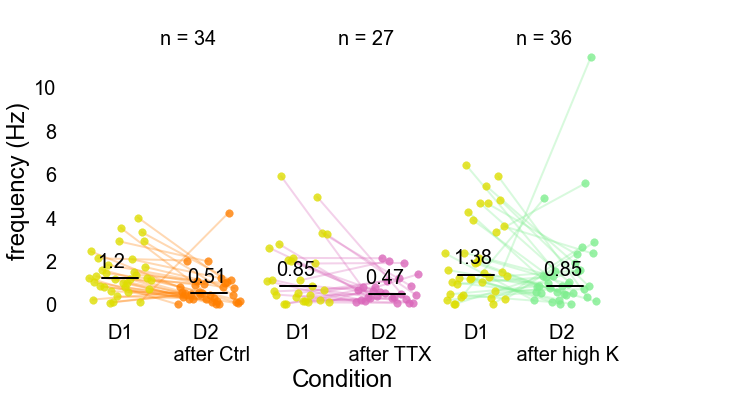

In [108]:
df = repatched_spontan
plt.style.use('./style_plot_intrinsic.mplstyle')
df = df.sort_values(['day', 'cell_ID'])
n_nums = n_nums_repatch
data_type = 'repatch'

colors = ['#dede00', '#ff7f00', '#dede00', '#DA67BA', '#dede00', '#7FEE8F'] #Ctrl, TTX, 8mM Kcl, 15 mM Kcl
keys_ordered = ['D1 Ctrl', 'D2 Ctrl', 'D1 TTX', 'D2 TTX', 'D1 high K', 'D2 high K']


plt.style.use('./style_plot_intrinsic.mplstyle')
title1 = 'Spontaneous EPSCs'
cmap = plt.cm.get_cmap('tab20')
op_color_dict = {}
for h, op in enumerate(df['OP'].unique()):
    op_color_dict[op] = cmap((h+1)/10)

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
day_label = []

min_h_incubation = str(min(df['hrs_incubation']))
min_amplitude = str(min(df['frequency']))[:4]
x_plot = []
for i, comb in enumerate(keys_ordered):
    k = 0 + i
    day = comb[:2]
    treatment = comb[3:]
    plot_df = df[(df['treatment'] == treatment) & (df['day'] == day)]
    x = np.linspace(0.65+k, 1.35+k, len(plot_df))
    x_plot.append(x)
    y = plot_df['frequency']
    median = np.median(y)
    ax.scatter(x, y, alpha = 0.8, c = colors[k], s = 60)
    ax.plot([0.8+k, 1.2+k], [median, median], c = 'k', linestyle = 'solid', linewidth = 2)
    day_label.append(comb)
    ax.text(k+0.75, median + 0.5, str(round(median, 2)), size = text_means)
    if k in [1,3,5] and data_type == 'repatch':
        for c, cell in enumerate(plot_df['cell_ID']):
            x1 = [x_plot[0][c], x[c]] 
            y = df['frequency'][df['cell_ID'] == cell]
            op = plot_df['OP'][plot_df['cell_ID'] == cell].tolist()[0]
            plt.plot(x1, y, '-', color = colors[k], alpha = 0.3, zorder = -1)
        title1 = 'Spontaneous EPSCs (repatch)'
        ax.text(k+ 0.45, int(np.max(df['frequency'])+1), 'n = ' + str(n_nums[comb]), size = text_)
        x_plot = []

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(ticks = list(range(1,7)), \
    labels = ['D1', 'D2 \n after Ctrl', 'D1', 'D2 \n after TTX','D1', 'D2 \n after high K'],\
     size = font_size_x_ticks)
ax.set_yticks([0,2,4,6,8,10], fontsize = font_size_y_ticks)
ax.tick_params(axis='y', labelsize = font_size_y_ticks)
#plt.title(title1, fontsize = 19, x = 0.5, y = 1)
ax.set_xlabel('Condition', fontsize = font_size_x_ticklabels)
ax.set_ylabel('frequency (Hz)', fontsize = font_size_y_ticklabels)
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.figlegend(loc = 'upper right',  bbox_to_anchor=(1, 1))
#fig.tight_layout()
fig.patch.set_facecolor('white')
#plt.show(fig)
plt.savefig(save_dir  + data_type + '_spontan_freq' '.pdf')
#plt.close(fig)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


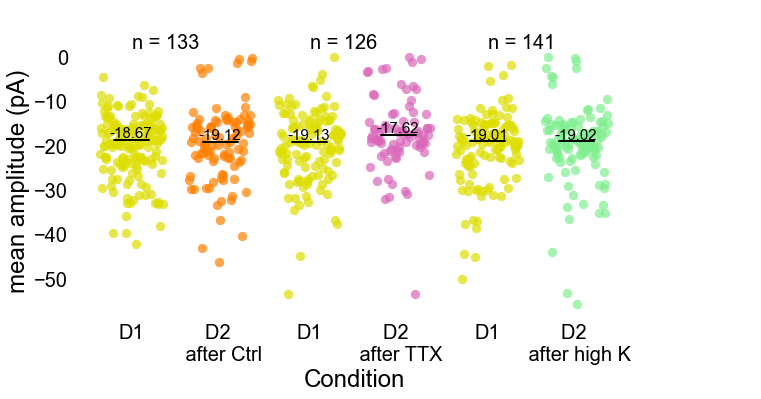

In [109]:
df = df_spontan[df_spontan['repatch'] == 'no']
df = df[df['amplitude mean'] > -90]
n_nums = n_nums_slice
data_type = 'spontan slice'

colors = ['#dede00', '#ff7f00', '#dede00', '#DA67BA', '#dede00', '#7FEE8F'] #Ctrl, TTX, 8mM Kcl, 15 mM Kcl

title1 = 'Spontaneous EPSCs'
cmap = plt.cm.get_cmap('tab20')
op_color_dict = {}
for h, op in enumerate(df['OP'].unique()):
    op_color_dict[op] = cmap((h+1)/10)

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
day_label = []

min_h_incubation = str(min(df['hrs_incubation']))
min_amplitude = str(min(df['amplitude mean']))[:4]
x_plot = []
for i, comb in enumerate(n_nums.keys()):
    k = 0 + i
    day = comb[:2]
    treatment = comb[3:]
    plot_df = df[(df['treatment'] == treatment) & (df['day'] == day)]
    x = np.linspace(0.65+k, 1.35+k, len(plot_df))
    x_plot.append(x)
    y = plot_df['amplitude mean']
    median = np.median(y)
    ax.scatter(x, y, alpha = 0.7, c = colors[k], s = 80)
    ax.plot([0.8+k, 1.2+k], [median, median], c = 'k', linestyle = 'solid', linewidth = 2)
    day_label.append(comb)
    ax.text(k+0.75, median + 0.5, str(round(median, 2)), size = 15)
    if k in [1,3,5]:
        ax.text(k, int(np.max(df['amplitude mean'])+3), 'n = ' + str(n_nums[comb]), size = text_)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(ticks = list(range(1,7)), \
    labels = ['D1', 'D2 \n after Ctrl', 'D1', 'D2 \n after TTX','D1', 'D2 \n after high K'],\
     size = font_size_x_ticks)
ax.set_yticks([0,-10,-20,-30,-40,-50]) 
ax.tick_params(axis='y', labelsize = font_size_y_ticks)
ax.set_xlabel('Condition', fontsize = font_size_x_ticklabels)
ax.set_ylabel('mean amplitude (pA)', fontsize = font_size_y_ticklabels)
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.figlegend(loc = 'upper right',  bbox_to_anchor=(1, 1))
#fig.tight_layout()
fig.patch.set_facecolor('white')
#plt.show(fig)
plt.savefig(save_dir  + data_type + '_spotan_amplitude.pdf')
#plt.close(fig)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


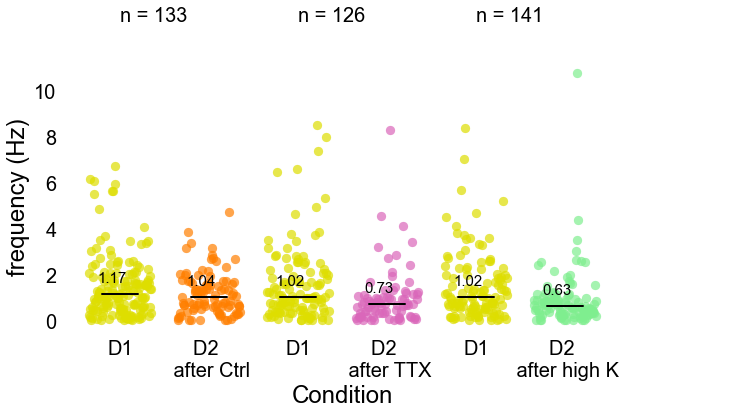

In [110]:
#df = df_spontan[df_spontan['repatch'] == 'no']
#df = df[df['frequency'] > -90]
# n_nums = n_nums_slice
# data_type = 'spontan slice'

colors = ['#dede00', '#ff7f00', '#dede00', '#DA67BA', '#dede00', '#7FEE8F'] #Ctrl, TTX, 8mM Kcl, 15 mM Kcl

title1 = 'Spontaneous EPSCs'
cmap = plt.cm.get_cmap('tab20')
op_color_dict = {}
for h, op in enumerate(df['OP'].unique()):
    op_color_dict[op] = cmap((h+1)/10)

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
day_label = []

min_h_incubation = str(min(df['hrs_incubation']))
min_amplitude = str(min(df['frequency']))[:4]
x_plot = []
for i, comb in enumerate(n_nums.keys()):
    k = 0 + i
    day = comb[:2]
    treatment = comb[3:]
    plot_df = df[(df['treatment'] == treatment) & (df['day'] == day)]
    x = np.linspace(0.65+k, 1.35+k, len(plot_df))
    x_plot.append(x)
    y = plot_df['frequency']
    median = np.median(y)
    ax.scatter(x, y, alpha = 0.7, c = colors[k], s = 80)
    ax.plot([0.8+k, 1.2+k], [median, median], c = 'k', linestyle = 'solid', linewidth = 2)
    day_label.append(comb)
    ax.text(k+0.75, median + 0.5, str(round(median, 2)), size = 15)
    if k in [1,3,5]:
        ax.text(k, int(np.max(df['frequency'])+3), 'n = ' + str(n_nums[comb]), size = text_)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(ticks = list(range(1,7)), \
    labels = ['D1', 'D2 \n after Ctrl', 'D1', 'D2 \n after TTX','D1', 'D2 \n after high K'],\
     size = font_size_x_ticks)
ax.set_yticks([0,2,4,6,8,10], fontsize = font_size_y_ticks)
ax.tick_params(axis='y', labelsize = font_size_y_ticks)
ax.set_xlabel('Condition', fontsize = font_size_x_ticklabels)
ax.set_ylabel('frequency (Hz)', fontsize = font_size_y_ticklabels)
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.figlegend(loc = 'upper right',  bbox_to_anchor=(1, 1))
#fig.tight_layout()
fig.patch.set_facecolor('white')
#plt.show(fig)
plt.savefig(save_dir  + data_type + '_spotan_freq.pdf')
#plt.close(fig)

